In [1]:
pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 74.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 81.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 37.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import utils
from astroNN.datasets import galaxy10sdss
from tensorflow import keras
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dense,Dropout,Flatten,AveragePooling2D,GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from keras.optimizers import schedules
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import h5py 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
with h5py.File('/kaggle/input/galaxy9/Galaxy9.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)


In [4]:
features = ['Disk, Face-on, No Spiral',' Smooth, Completely round','Smooth, in-between round','Smooth, Cigar shaped','Disk, Edge-on, Rounded Bulge','Disk, Edge-on, No Bulge','Disk, Face-on, Tight Spiral','Disk, Face-on, Medium Spiral','Disk, Face-on, Loose Spiral']
features[np.argmax(labels[33])]

'Disk, Face-on, No Spiral'

In [5]:
x_train.shape, x_test.shape

((17414, 69, 69, 3), (4354, 69, 69, 3))

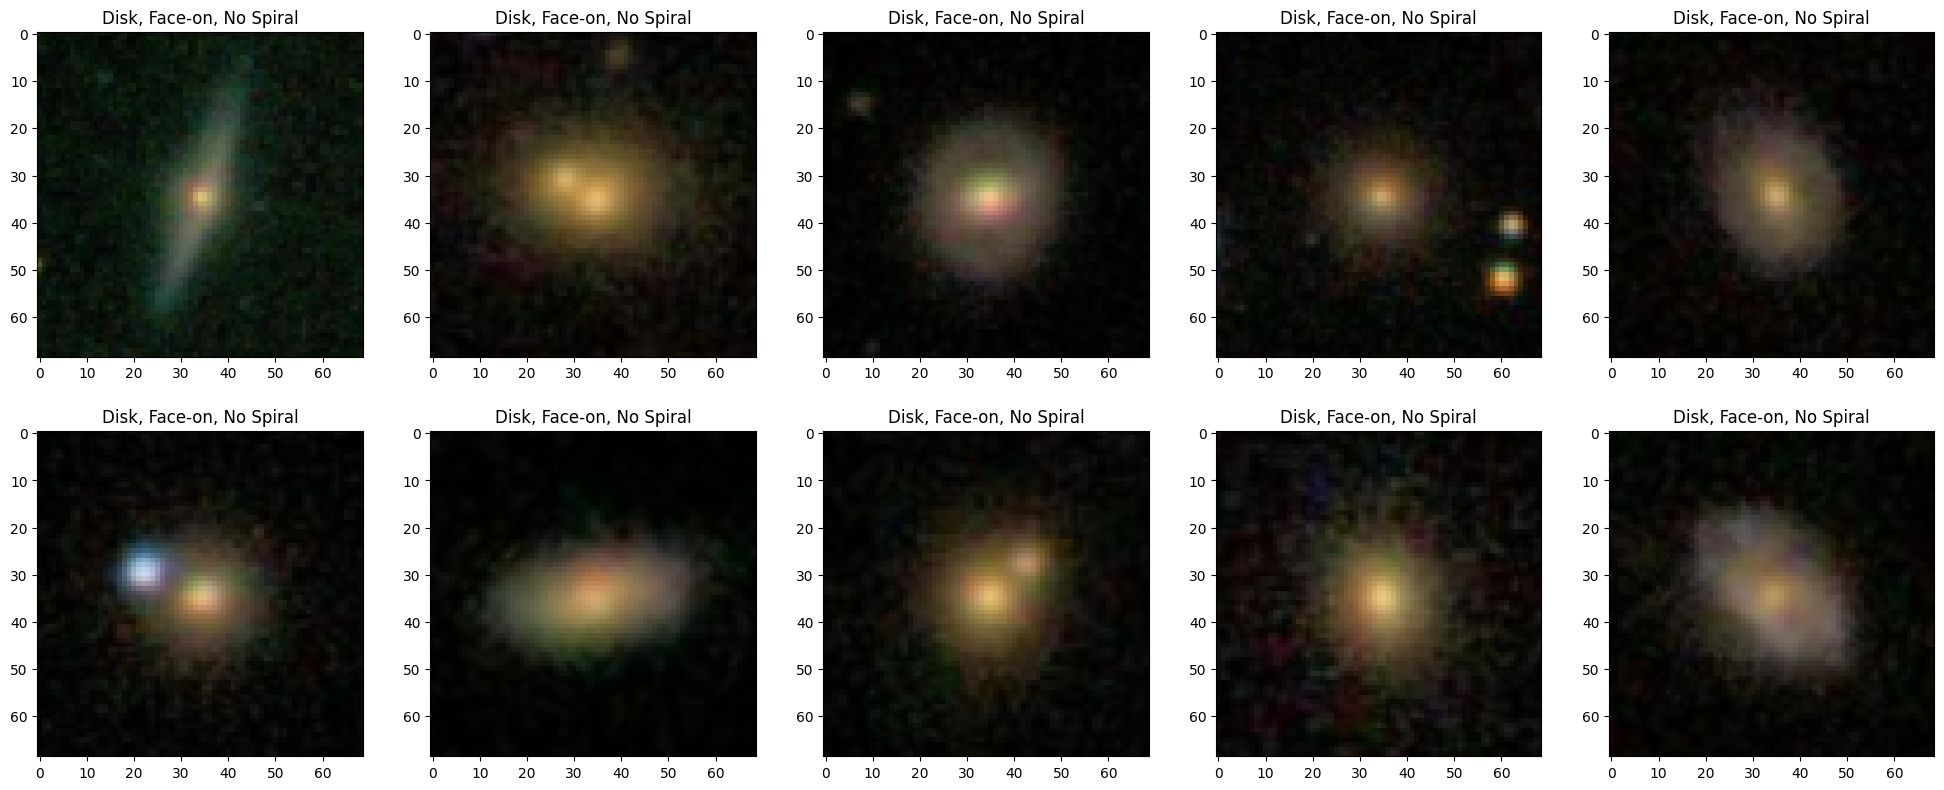

In [6]:
fig = plt.figure(figsize=(20,20))

for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
    plt.title(features[np.argmax(y_train[i])])
    fig.tight_layout(pad=2.0)

plt.show()

In [7]:
print(labels.shape)
print(features)

(21768,)
['Disk, Face-on, No Spiral', ' Smooth, Completely round', 'Smooth, in-between round', 'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, No Bulge', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral']


In [8]:
df = pd.DataFrame(data=labels)
print(df.keys())
counts = df.value_counts().sort_index()
g  = pd.DataFrame(data={"Type of Galaxy":features,"Number of Images":counts})
print(g)

RangeIndex(start=0, stop=1, step=1)
                 Type of Galaxy  Number of Images
0                                                
0      Disk, Face-on, No Spiral              3461
1      Smooth, Completely round              6997
2      Smooth, in-between round              6292
3          Smooth, Cigar shaped               349
4  Disk, Edge-on, Rounded Bulge              1534
5       Disk, Edge-on, No Bulge               589
6   Disk, Face-on, Tight Spiral              1121
7  Disk, Face-on, Medium Spiral               906
8   Disk, Face-on, Loose Spiral               519


In [9]:
X_test=x_test/np.max(x_test)
X_train=x_train/np.max(x_train)

In [10]:

y_train = utils.to_categorical(y_train, num_classes=9)
y_test = utils.to_categorical(y_test, num_classes=9)
print(y_train.shape)
print(y_test.shape)

(17414, 9)
(4354, 9)


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow(x_train,y_train,
                                     batch_size=32 )

Val_generator = test_datagen.flow(x_test,y_test,
                                     batch_size=32)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)

lr_schedule = schedules.ExponentialDecay( initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9, staircase=True)

callback = EarlyStopping(monitor="val_loss", min_delta=1e-8, patience=20, verbose=0, mode="auto")

In [14]:
optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:

model = keras.Sequential([
        #block1
        Conv2D(filters= 64, kernel_size = (3,3), padding = "valid", strides = (1,1),input_shape=(69,69,3),activation='relu'),
        BatchNormalization(),
        Conv2D(filters= 64, kernel_size = (3,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2),strides = (2,2)),

        #block2
        Conv2D(filters= 128, kernel_size = (3,3)),
        BatchNormalization(),
        Conv2D(filters= 128, kernel_size = (3,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2),strides = (2,2)),

        #block3
        Conv2D(filters= 256, kernel_size = (3,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2),strides = (2,2)),
        Conv2D(filters= 256, kernel_size = (3,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2),strides = (2,2)),
        GlobalAveragePooling2D(),

        Flatten(),
        Dense(512,activation="relu",kernel_regularizer=l2(0.001)),
        Dropout(rate=0.5),
        Dense(256,activation="relu",kernel_regularizer=l2(0.001)),
        Dropout(rate=0.3),
        Dense(128,activation="relu",kernel_regularizer=l2(0.001)),
        Dense(9,activation="softmax")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 67, 67, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 67, 67, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 65, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 65, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,445,961 (5.52 MB)

 Trainable params: 1,444,169 (5.51 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [17]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
Galaxy_model = model.fit(train_generator,epochs=100 ,batch_size=32,validation_data=Val_generator,callbacks=[reduce_lr])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
I0000 00:00:1731235811.319408     116 service.cc:145] XLA service 0x7c3a80001fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731235811.319472     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/545 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.2253 - loss: 3.2018 

I0000 00:00:1731235819.390891     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - accuracy: 0.4046 - loss: 2.1757 - val_accuracy: 0.4293 - val_loss: 1.7992 - learning_rate: 5.9049e-04
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.5657 - loss: 1.5036 - val_accuracy: 0.5064 - val_loss: 1.5484 - learning_rate: 3.4868e-04
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.6589 - loss: 1.2153 - val_accuracy: 0.6031 - val_loss: 1.3105 - learning_rate: 1.8530e-04
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.6892 - loss: 1.0916 - val_accuracy: 0.5514 - val_loss: 1.4420 - learning_rate: 1.0942e-04
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.7049 - loss: 1.0270 - val_accuracy: 0.7529 - val_loss: 0.9055 - learning_rate: 5.8150e-05
Epoch 6/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.7210 - loss: 0.9814 - val_accuracy: 0.7685 - val_loss: 0.8432 - learning_rate: 3.4337e-05
Epoch 7/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - a

KeyboardInterrupt: 

In [20]:
model.evaluate(X_test,y_test)

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8337 - loss: 0.5401


[0.5184000730514526, 0.8403766751289368]

Index(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'], dtype='object')


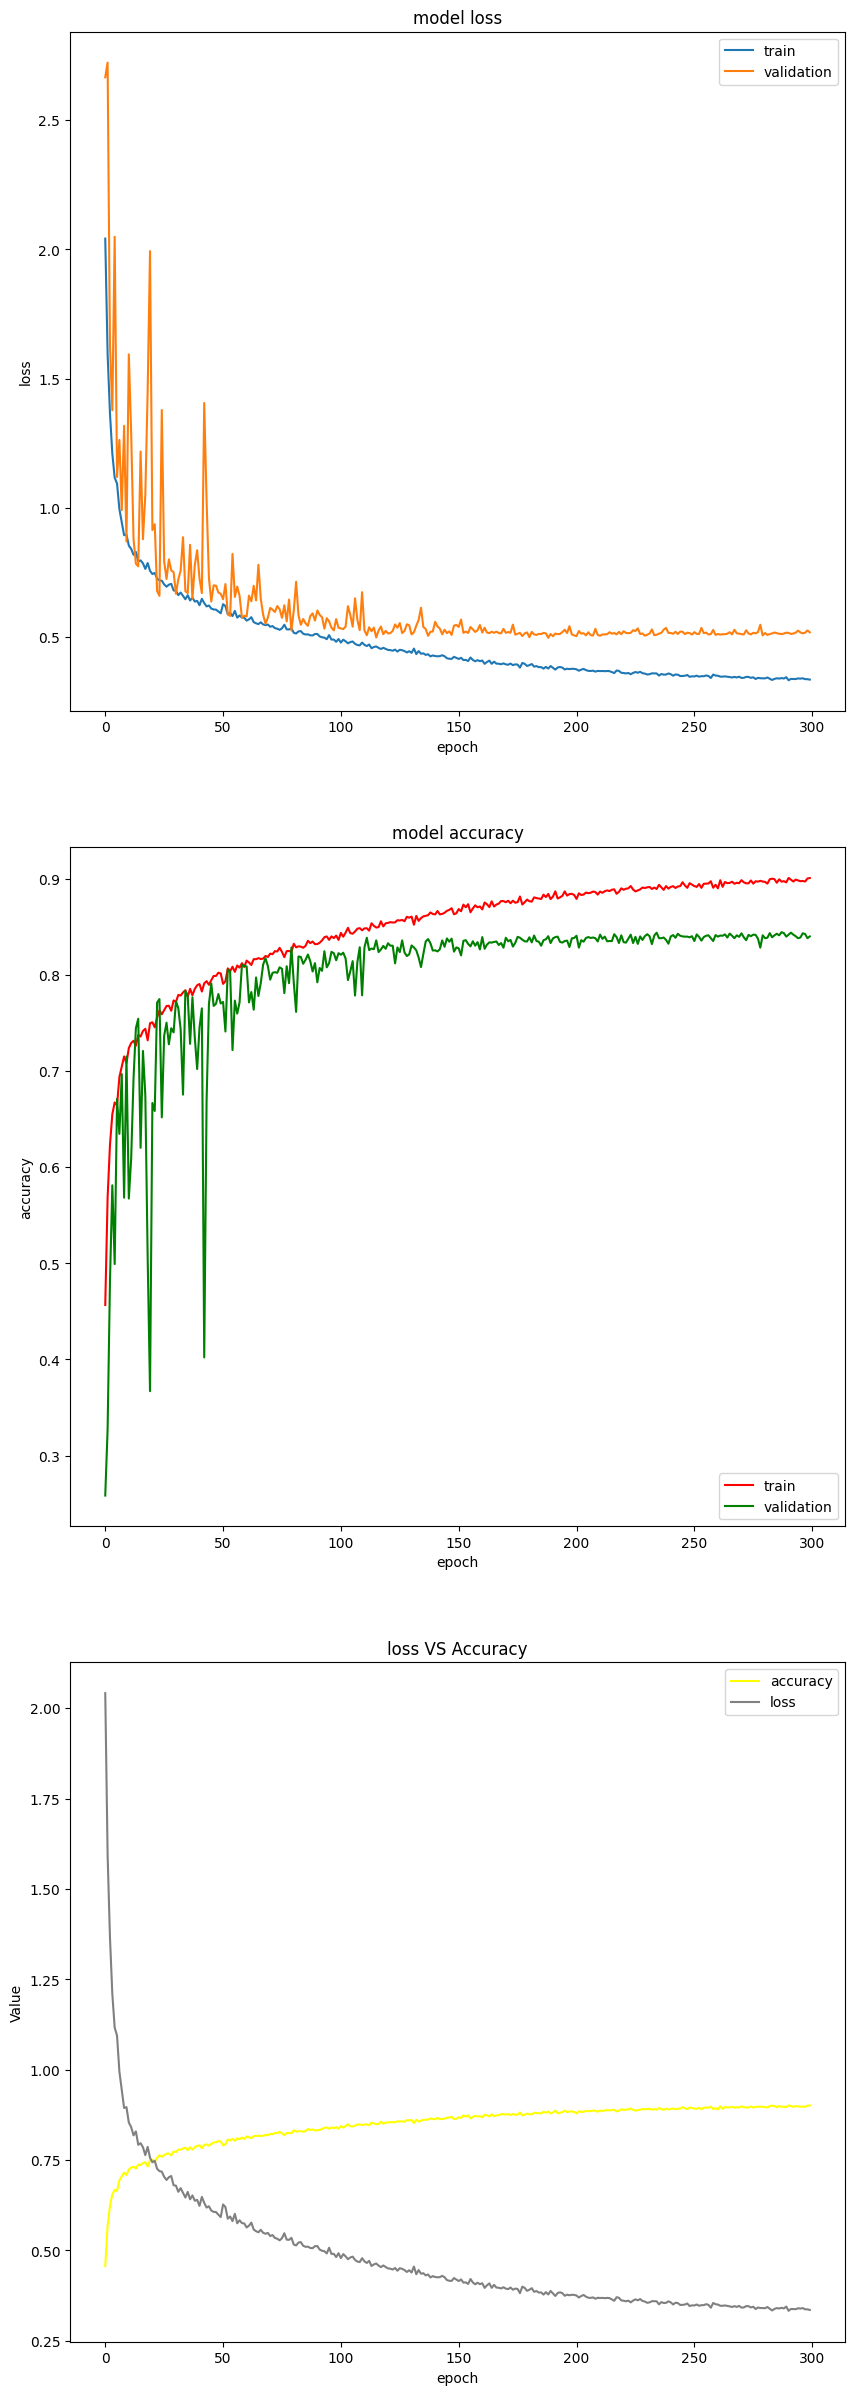

In [21]:
df = pd.DataFrame(Galaxy_model.history)
print(df.keys())
fig,ax = plt.subplots(3,1,figsize=(10,30))
#plotting loss per epoch
ax[0].plot(df['loss'])
ax[0].plot(df['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='upper right')
#plotting accuracy per epoch
ax[1].plot(df['accuracy'],color="red")
ax[1].plot(df['val_accuracy'],color="green")
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='lower right')

ax[2].plot(df['accuracy'],color="yellow")
ax[2].plot(df['loss'],color="grey")
ax[2].set_title('loss VS Accuracy')
ax[2].set_ylabel('Value')
ax[2].set_xlabel('epoch')
ax[2].legend(['accuracy', 'loss'], loc='upper right')

fig.savefig('128-batchsize.png')

In [22]:
y_test.shape

(4354, 9)

In [23]:
y_prediction = model.predict(X_test)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 500


predicted value is 2 percentage value 99.20898675918579%
It is a  Smooth, in-between round


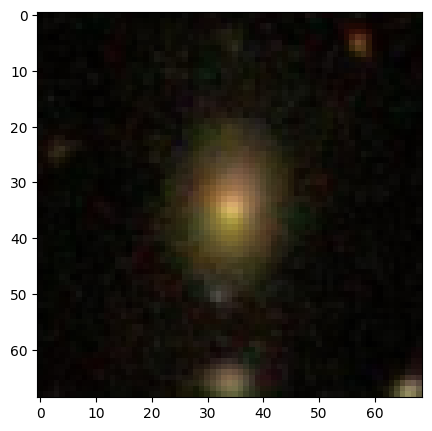

In [24]:
i=int(input())
print("predicted value is {} percentage value {}%".format(np.argmax(y_prediction[i]),100*np.max(y_prediction[i])))
print("It is a ",features[np.argmax(y_prediction[i])])
plt.figure(figsize=(15,5))
plt.imshow(x_test[i])

In [25]:
Pred = y_prediction.argmax(axis=1)
z = y_test.argmax(axis=1)
print(z.shape)
print(Pred.shape)

(4354,)
(4354,)


In [26]:
print(classification_report(z, Pred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       705
           1       0.87      0.95      0.91      1415
           2       0.89      0.88      0.88      1267
           3       0.82      0.73      0.77        63
           4       0.90      0.92      0.91       297
           5       0.87      0.85      0.86       119
           6       0.72      0.72      0.72       222
           7       0.71      0.52      0.60       174
           8       0.69      0.64      0.67        92

    accuracy                           0.84      4354
   macro avg       0.80      0.76      0.78      4354
weighted avg       0.84      0.84      0.84      4354



In [27]:
cm = confusion_matrix(z,Pred)

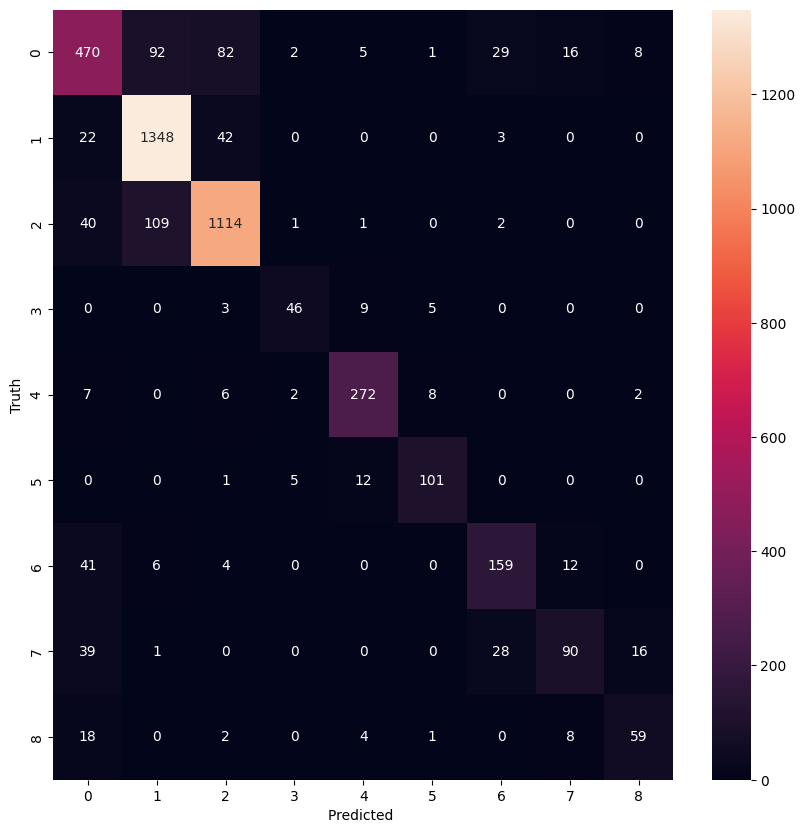

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel( 'Predicted ' )
plt.ylabel( 'Truth' )
plt.savefig("Confusion_maxtrix_128")